## Data sampling and visualization

We provide a sampler which can sample 2D labeled data points in predefined data distribution. In this assignment, we first sample the training and validation data then implement norm regularization and early stopping. To check the effects of each component, we visualize the classification result by plotting the zero-crossing line.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import edf
import copy

# you can change this if you want to see other cases.
np.random.seed(1234)

class Sampler:

    # hyperparameter for data distribution
    sigma =0.1 # scale of noisy 2D offset.
    radius = 0.3
    center_1 = [-0.5 * radius, -radius * 0.3 ]
    center_2 = [ 0.5 * radius, radius * 0.3 ]

    def __init__(self, sigma = 0.01):

        self.sigma = sigma

    def sample (self, sample_n = 10):

        samples_in_uniform_dist = np.random.rand ( sample_n, 4) # 4 random variables for each sample ( binary label, angle, x,y offset )

        X = np.zeros ( [sample_n , 2], dtype = np.float32 )
        y = np.zeros ( [sample_n , 1], dtype = np.int32)

        # sample the label
        y [samples_in_uniform_dist[:, 0]>0.5] = 1

        # sample the angle
        angles = samples_in_uniform_dist[ :, 1:2 ] * np.pi
        cos_thetas = np.cos ( angles )
        sin_thetas = np.sin ( angles )

        # sample the offset
        offsets = norm.ppf (samples_in_uniform_dist[:,2:4])* self.sigma
#        offsets = np.random.randn ( sample_n, 2 ) * self.sigma

        X[:, :1][y == 0] = cos_thetas[y==0] * self.radius + self.center_1[0]
        X[:, 1:2][y == 0] = sin_thetas[y==0] * self.radius + self.center_1[1]
        X[:, :1][y == 1] = cos_thetas[y==1] * self.radius + self.center_2[0]
        X[:, 1:2][y == 1] = -sin_thetas[y==1] * self.radius + self.center_2[1]

        # add x,y offset
        X += offsets

        y = y[:,0]

        return X,y


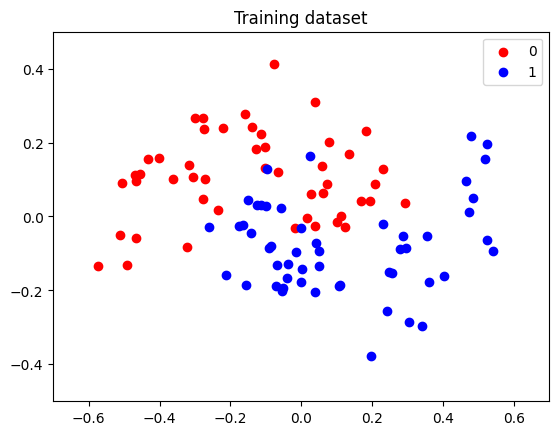

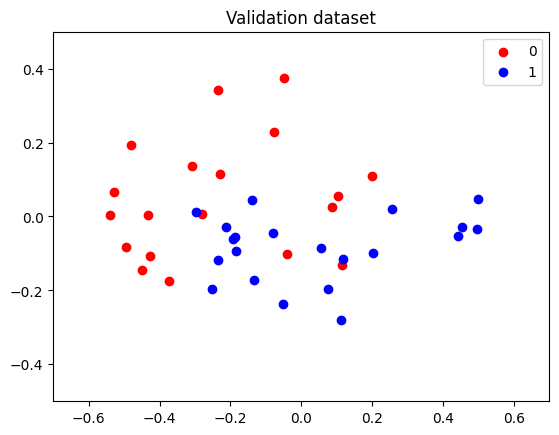

<Figure size 640x480 with 0 Axes>

In [2]:
# construct samplers for train and valid dataset.
sampler_train = Sampler(0.1)
sampler_valid = Sampler(0.1)

# sample training and validation data
X_train, y_train = sampler_train.sample(100)
X_valid, y_valid = sampler_valid.sample(40)

X = X_train
y = y_train

# plot point clouds
def plot(X0, X1, title_name="" ):
    
    plt.title(title_name)
    plt.scatter(X0[:,0], X0[:,1], color='red', label=0)
    plt.scatter(X1[:,0], X1[:,1], color='blue', label=1)
    
    plt.xlim([-0.7, 0.7])
    plt.ylim([-0.5, 0.5])
    plt.legend()
    plt.show()
    plt.clf()
    
# draw zero-crossing line (black line)
def plot_line (MLP):
    p = np.linspace(-0.5, 0.5, 500)
    x_plot, y_plot = np.meshgrid(p, p)
    X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)

    y_dummy = np.ones_like(X_plot[:,0], dtype=np.int32)
    #
    output = MLP.forward(X_plot)
    output_plot = np.round(output.reshape(x_plot.shape[0], x_plot.shape[1]))

    origin = 'lower'
    plt.contour(x_plot, y_plot, output_plot, [0.5],
                      colors=('k',),
                      linewidths=(3,),
                      origin=origin)

# plot training data and validation data
plot(X_train [y_train == 0], X_train [y_train == 1], title_name = 'Training dataset')
plot(X_valid [y_valid == 0], X_valid [y_valid == 1], title_name = 'Validation dataset')

In [3]:
# Provide the function that you need 
class SingleProbToProbVector(edf.CompNode):
    def __init__(self, z):
        edf.CompNodes.append(self)
        self.z = z

    def forward(self):
        self.value = np.repeat(self.z.value, 2, axis=1)
        self.value[:, 1] = 1 - self.value[:, 1]

    def backward(self):
        self.z.addgrad((self.grad[:, 0] - self.grad[:, 1]).reshape(-1, 1))

## Norm Penalty Regularization

We produce the multi-layer perceptron (MLP) class which support norm penalty regularization. The framework of network is defined so your task is to implement functional part of computational nodes: `L1NormPenalty` and `L2NormPenalty`. In `MLP` class, `Construct()` is the function which builds the computational graph for training in the EDF system. `Forward()` is to compute computational nodes in the forward fashion. `Record()` is to store/load the current status of the network. You don't have to see all of them but `Construct()`.

To help your understanding, I recommend you to draw the computational graph of a 2-hidden-layer MLP network including loss nodes.

In [5]:
# Hyperparameters for MLP
class MLPHyperParams:

    nInputs = None
    nHiddens = None
    nOutputs = None
    nLayers = None
    PenaltyNode = None
    enableReg = None
    alpha = None

# Multi-layer perceptron class
class MLP:

    def __init__(self, hyperParams: MLPHyperParams):

        self.hyperParams = hyperParams

    def construct(self):

        # local variable setting
        hyperParams = self.hyperParams

        nInputs = int(hyperParams.nInputs)
        nHiddens = int(hyperParams.nHiddens)
        nOutputs = int(hyperParams.nOutputs)
        nLayers = int(hyperParams.nLayers)
        enableReg = hyperParams.enableReg
        alpha = hyperParams.alpha

        PenaltyNode = hyperParams.PenaltyNode

        # clean global parameters
        edf.clear_compgraph()

        # input
        x_node = edf.Input()
        y_node = edf.Input()

        # initialize lists
        loss_nodes = []
        weight_params = []

        # 1st layer
        # We generate parameters and add them in the local parameter list ( for record )
        # we build a hidden layer as output of sigmoid of affine transformed signal x
        param_first = edf.AffineParams(nInputs, nHiddens)
        weight_params.append(param_first) # For record, add parameters in the local (in the instance) parameter list.
        h = edf.Sigmoid(edf.Affine(param_first, x_node))

        # Norm penalty
        # For each parameter nodes, we create a regularization node by making the instance of PenaltyClass.
        # PenaltyClass is a class which represents norm penalty.
        # By changing the penalty class, we can change the type of norm penalty such as L1 and L2 norm penalty.
        if enableReg:
            reg_loss_node = PenaltyNode(param_first.A, alpha)
            loss_nodes.append(reg_loss_node) # add the loss node in the loss node list 
            reg_loss_node = PenaltyNode(param_first.b, alpha)
            loss_nodes.append(reg_loss_node) # same as previous

        for i in range(nLayers - 1):

            # hidden layer
            param = edf.AffineParams(nHiddens, nHiddens)
            weight_params.append(param) # For record, we add them in the local parameter list in the instance.
            h = edf.Sigmoid(edf.Affine(param, h))

            # Norm penalty
            if enableReg:
                reg_loss_node = PenaltyNode(param.A, alpha)
                loss_nodes.append(reg_loss_node) # add the loss node in the loss node list 
                reg_loss_node = PenaltyNode(param.b, alpha)
                loss_nodes.append(reg_loss_node) # same as previous

        # the last layer
        param_last = edf.AffineParams(nHiddens, nOutputs)
        weight_params.append(param_last) # For record, we add them in the local parameter list in the instance.
        output_node = edf.Sigmoid(edf.Affine(param_last, h))

        # Norm penalty
        if enableReg:
            reg_loss_node = PenaltyNode(param_last.A, alpha)
            loss_nodes.append(reg_loss_node) # add the loss node in the loss node list 
            reg_loss_node = PenaltyNode(param_last.b, alpha)
            loss_nodes.append(reg_loss_node) # same as previous

        # cross entropy loss
        prob_node = SingleProbToProbVector(output_node)
        crossloss_node = edf.CrossEntropyLoss(prob_node, y_node)

        # average cross entropy loss over a minibatch
        crossloss_avg_node = AverageMiniBatch(crossloss_node) 
        loss_nodes.append(crossloss_avg_node)

        # store loss node and output node
        self.prob_node = prob_node
        self.output_node = output_node
        self.total_loss_node = Add(loss_nodes) # we sum all scalar losses.
        self.x_node = x_node
        self.y_node = y_node
        self.weight_params = weight_params

    def forward(self, X, y=None):

        if y is None:
            y = np.ones_like ( X[:,0], dtype =np.int32 )
        
        # parse input
        self.x_node.value = X
        self.y_node.value = y

        # run
        edf.Forward()

        # get output
        output = np.round(self.output_node.value)

        return output

    def load (self):
        
        # local variable setting
        hyperParams = self.hyperParams

        nInputs = int(hyperParams.nInputs)
        nHiddens = int(hyperParams.nHiddens)
        nOutputs = int(hyperParams.nOutputs)
        nLayers = int(hyperParams.nLayers)
        enableReg = hyperParams.enableReg
        alpha = hyperParams.alpha
        PenaltyNode = hyperParams.PenaltyNode
        
        # load overall parameters from the recorded instance
        self.weight_params = self.rep.weight_params
        
        # clean global parameters
        edf.clear_compgraph()

        # input
        x_node = edf.Input()
        y_node = edf.Input()

        loss_nodes = []
        # 1st layer

        param_first = self.weight_params[0]
        h = edf.Sigmoid(edf.Affine(param_first, x_node))

        # reg
        if enableReg:
            reg_loss_node = PenaltyNode(param_first.A, alpha)
            loss_nodes.append(reg_loss_node)
            reg_loss_node = PenaltyNode(param_first.b, alpha)
            loss_nodes.append(reg_loss_node)

        for i in range(nLayers - 1):

            # hidden layer
            param = self.weight_params[i+1]
            h = edf.Sigmoid(edf.Affine(param, h))

            # reg
            if enableReg:
                reg_loss_node = PenaltyNode(param.A, alpha)
                loss_nodes.append(reg_loss_node)
                reg_loss_node = PenaltyNode(param.b, alpha)
                loss_nodes.append(reg_loss_node)

        # the last layer
        param_last = self.weight_params[-1]
        output_node = edf.Sigmoid(edf.Affine(param_last, h))

        # reg loss
        if enableReg:
            reg_loss_node = PenaltyNode(param_last.A, alpha)
            loss_nodes.append(reg_loss_node)
            reg_loss_node = PenaltyNode(param_last.b, alpha)
            loss_nodes.append(reg_loss_node)

        # cross entropy loss
        prob_node = SingleProbToProbVector(output_node)
        crossloss_node = edf.CrossEntropyLoss(prob_node, y_node)
        crossloss_avg_node = AverageMiniBatch(crossloss_node)
        loss_nodes.append(crossloss_avg_node)

        # store loss node and output node
        self.prob_node = prob_node
        self.output_node = output_node
        self.total_loss_node = Add(loss_nodes)
        self.x_node = x_node
        self.y_node = y_node

    def record(self):
        self.rep = copy.deepcopy(self)

To compute the total loss as the single scalar value, we add new computational nodes: `Add` and `AverageMiniBatch`. We first compute an average of the cross-entropy losses over minibatches then we sum all losses as the total loss: regularization loss for each parameter and the average of the cross-entropy losses over minibatches. In this way, we donot have to modify `edf.py` at all.

In [6]:
class Add(edf.CompNode):

    def __init__(self, x_list):
        edf.CompNodes.append(self)
        self.x_list = x_list

    def forward(self):

        value = np.zeros_like(self.x_list[0].value, self.x_list[0].value.dtype)

        for x in self.x_list:
            value += x.value

        self.value = value

    def backward(self):

        for x in self.x_list:
            x.addgrad(np.ones_like(x.value, x.value.dtype)  * self.grad[0])

class AverageMiniBatch(edf.CompNode):

    def __init__(self, x):
        
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):

        value = np.average(self.x.value)
        self.value = np.resize(value, (1, 1))

    def backward(self):

        self.x.addgrad(np.ones_like(self.x.value, self.x.value.dtype)/self.x.value.size * self.grad[0])

### Training and visualization of the network trained without norm regularization

In [7]:
def train(num_steps, x, y, x_node, y_node, prob_node, loss_node):

    x_node.value = x
    y_node.value = y
    dataset_size = x.shape[0]
    
    for iteration in range(1, num_steps + 1):
        
        edf.Forward()
        total_err = np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

        edf.Backward(loss_node)
        edf.UpdateParameters()
        
        if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
            print('iter: {}, error: {:6f}'.format(iteration, total_err))

Let us get familiar with the `MLP` class. By passing proper hyperparameters, we can construct the `MLP` instance which can construct the MLP nework in the `edf` system on our purpose. In the following code by disenabling norm penalty regularization, our `MLP` instance construct the MLP network without norm penalty regularization. 

In [8]:
hyperParams = MLPHyperParams()

hyperParams.nInputs = 2
hyperParams.nHiddens = 16
hyperParams.nOutputs = 1 
hyperParams.nLayers= 2

## You have to see these two lines. ##
hyperParams.enableReg = False ## THESE
hyperParams.PenaltyNode = None            ## LINES

hyperParams.alpha = 0.000

MLP_no_reg = MLP ( hyperParams )
MLP_no_reg.construct()

#training
num_steps = 20000
learning_rate = 1
edf.learning_rate = learning_rate

train(num_steps, X, y, MLP_no_reg.x_node, MLP_no_reg.y_node, MLP_no_reg.prob_node, MLP_no_reg.total_loss_node)


iter: 100, error: 28.000000
iter: 200, error: 23.000000
iter: 500, error: 22.000000
iter: 1000, error: 21.000000
iter: 5000, error: 6.000000
iter: 10000, error: 6.000000
iter: 20000, error: 5.000000


Then we visualize the zero-crossing line with the training dataset and the validation dataset.

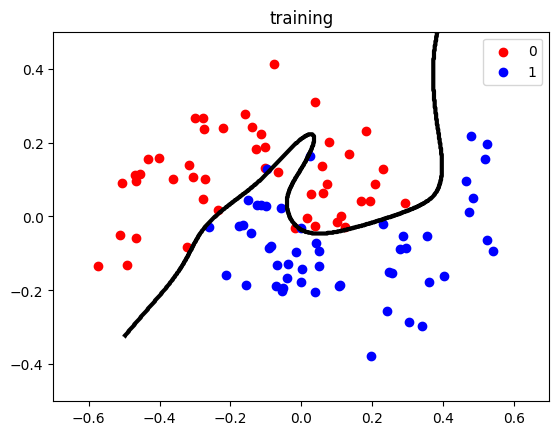

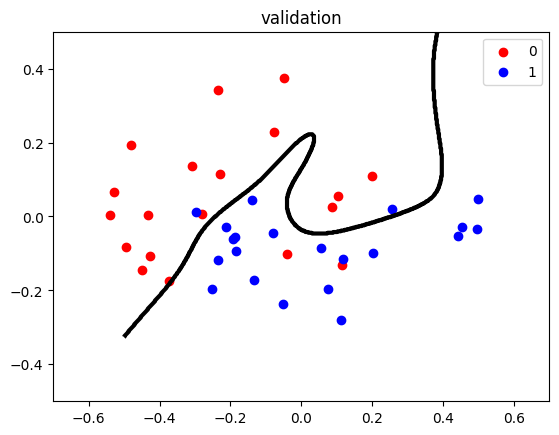

<Figure size 640x480 with 0 Axes>

In [9]:
plot_line (MLP_no_reg)
plot(X_train[y_train==0], X_train[y_train==1], title_name = 'training')

plot_line (MLP_no_reg)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name = 'validation')


### Training and visualization of the network trained with L1 regularization

We can build a MLP network with norm penalty terms by passing a norm penalty class as a parameter. Let us construct a MLP network with `L1` norm regularization, train the network then see the classification result.

Your task is to fill part of `L1NormPenalty` class which represents L1 norm penalty. In `forward` function, you compute a scalar value of the L1-norm penalty. In `backward`, you have to compute the gradient of L1-norm penalty.

In [ ]:

class L1NormPenalty(edf.CompNode):

    def __init__(self, x, alpha):
        edf.CompNodes.append(self)
        self.x = x
        self.alpha = alpha

    def forward(self):

        ###############################################
        # TO-DO : Implement a forward part.
        # Compute the L1-norm penalty of the parameters
        # You should store a scalar value in variable 'value'.

        # ex:
        # value = 
        ###############################################
        
        self.value = np.resize(value, (1, 1))
        
        
    def backward(self):
        
        ###############################################
        # TO-DO : Implement a backward part.
        # Compute the gradient of L1 norm penalty and do backward propagation
        ###############################################


Now we generate the `MLP` object with L1 norm penalty. By setting the hyperparameter of the penalty node class properly, our `MLP` instance constructs the computational graph in the `edf` system automatically.

In [ ]:
hyperParams = MLPHyperParams()

hyperParams.nInputs = 2
hyperParams.nHiddens = 16
hyperParams.nOutputs = 1 
hyperParams.nLayers= 3
hyperParams.enableReg = True

###############################################
# TO-DO : assign the proper PenaltyNode class to the MLP hyperparameter.
# Hint: hyperParams.PenaltyNode = 
###############################################

hyperParams.PenaltyNode = 
hyperParams.alpha = 0.001

MLP_with_L1 = MLP ( hyperParams )
MLP_with_L1.construct()

#training
num_steps = 20000
learning_rate = 1
edf.learning_rate = learning_rate

train(num_steps, X, y, MLP_with_L1.x_node, MLP_with_L1.y_node, MLP_with_L1.prob_node, MLP_with_L1.total_loss_node)

Then we visualize the zero-crossing line with the training dataset and the validation dataset.

In [ ]:
plot_line (MLP_with_L1)
plot(X_train[y_train==0], X_train[y_train==1], title_name = 'training')

plot_line (MLP_with_L1)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name = 'validation')


### Training and visualization of the network trained with L2 regularization

Your task is to fill part of `L2NormPenalty` class which represents L2 norm penalty. In `forward` function, you compute a scalar value of the L2 norm penalty. In `backward`, you have to compute the gradient of L2 norm penalty.

In [ ]:
class L2NormPenalty(edf.CompNode):

    def __init__(self, x, alpha):
        edf.CompNodes.append(self)
        self.x = x
        self.alpha = alpha

    def forward(self):

        ###############################################
        # TO-DO : Implement a forward part.
        # Compute the L2-norm penalty of the parameters
        # You should store a scalar value in variable 'value'.
        # ex:
        # value = 
        ###############################################

        
        self.value = np.resize(value, (1, 1))

    def backward(self):

        ###############################################
        # TO-DO : Implement a backward part.
        # Compute the gradient of L2 norm penalty and do backward propagation
        ###############################################


Like the previous, we generate the `MLP` object with L2 norm penalty.

In [ ]:
hyperParams = MLPHyperParams()

hyperParams.nInputs = 2
hyperParams.nHiddens = 16
hyperParams.nOutputs = 1 
hyperParams.nLayers= 2
hyperParams.enableReg = True

###############################################
# TO-DO : assign the L2 PenaltyNode class to the MLP hyperparameter.
# Hint: hyperParams.PenaltyNode = 
###############################################

hyperParams.PenaltyNode = 
hyperParams.alpha = 0.001

MLP_with_L2 = MLP ( hyperParams )
MLP_with_L2.construct()

#training
num_steps = 20000
learning_rate = 1
edf.learning_rate = learning_rate

train(num_steps, X, y, MLP_with_L2.x_node, MLP_with_L2.y_node, MLP_with_L2.prob_node, MLP_with_L2.total_loss_node)

Then we visualize the zero-crossing line with the training dataset and the validation dataset.

In [ ]:
plot_line (MLP_with_L2)
plot(X_train[y_train==0], X_train[y_train==1], title_name = 'training')

plot_line (MLP_with_L2)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name = 'validation')

## Early stopping

Implement early stopping. By using `MLP.record()`, you can record the current state in `MLP.rep` variable. Your task is to call `MLP.record()` when a minimum of a validation error decreases. If it does not decrease for the certain number of iterations, we stop training. To this end, we give two arguments: `validation_step` and `max_passed_step`. We compute the validation error and do early stopping test for each `validation_step` step. If there is no renew of the validation minimum for `max_passed_step`, we finalize the training session.

In [ ]:
def train_early_stopping(num_steps, x_train, y_train, x_valid, y_valid, x_node, y_node, prob_node, loss_node, MLP, validation_step = 100, max_passed_step = 5000):

    dataset_size = x_train.shape[0]
    
    validation_error = 10
    
    ###############################################
    # How to find a minimum value in the list.
    #
    # first initialize the minimum as the big number. (or set the first element value. )
    # Then, renew the minimum during iteration.
    #
    # ex)
    # min_value = 100000
    # for i in range(len(sequence)):
    #        if sequence[i] < min_value:
    #            min_value = sequence[i]
    ###############################################
    
    ###############################################
    # TO-DO : Initialize the current minimum variable
    #    
    ###############################################
    
    for iteration in range(1, num_steps + 1):
       
        if iteration % validation_step == 0:
            
            x_node.value = x_valid
            y_node.value = y_valid

            edf.Forward()

            current_err_valid = np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

            print('iter: {}, error: {:6f} {:6f}'.format(iteration, current_err_train, current_err_valid),end='')

            ###############################################
            # TO-DO : 
            # when the current validation error is minimum over all iterations, record the current parameter status.
            # If the number of passed steps is over than the certain number of steps, finalize the training session.

            # Hint : you can use MLP.record() to store the status
            ###############################################
            
            print('')

    
        x_node.value = x_train
        y_node.value = y_train
        
        edf.Forward()
                
        current_err_train = np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

        edf.Backward(loss_node)
        edf.UpdateParameters()
        
        # print(loss_node.value.mean())

Then, let us test how our early stopping works. To test it, we build a MLP network without norm penalty. Then, we train the network in the early-stopping fashion.

In [ ]:
hyperParams = MLPHyperParams()

hyperParams.nInputs = 2
hyperParams.nHiddens = 16
hyperParams.nOutputs = 1 
hyperParams.nLayers= 2

## You have to see these two lines. ##
hyperParams.enableReg = False ## THESE
hyperParams.PenaltyNode = None            ## LINES !!

hyperParams.alpha = 0.000

MLP_no_reg = MLP ( hyperParams )
MLP_no_reg.construct()

#training
num_steps = 20000
learning_rate = 1
edf.learning_rate = learning_rate

train_early_stopping(num_steps, X_train, y_train, X_valid, y_valid, MLP_no_reg.x_node, MLP_no_reg.y_node, MLP_no_reg.prob_node, MLP_no_reg.total_loss_node, MLP_no_reg, validation_step = 100, max_passed_step =5000)


Then we visualize the zero-crossing line with the training dataset and the validation dataset. `MLP.load` loads all recorded parameters and constructs the MLP network in the `edf` system.

In [ ]:
MLP_no_reg.load()

plot_line (MLP_no_reg)
plot(X_train[y_train==0], X_train[y_train==1], title_name = 'training')

plot_line (MLP_no_reg)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name = 'validation')
